In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

In [ ]:
fsd = "first_submission_date"

In [17]:
# Convert the date to datetime
df_dt = df.copy()
df_dt[fsd] = df_dt[fsd].apply(lambda t: pd.to_datetime(t, unit='s'))

- For each year $i$ I do a cut: $years \leq i$ as training set, $years > i$ as test set.
- Next, for both the timespans, for each malware family I plot the histogram to count the occurrences of each family
- Then, I compute the KL divergence of the two arrays
- Finally, I plot a histogram for each split where each bin is the computed KL divergence between training and test. 
- In the end I get the maximum KL divergence.

In [46]:
fsd = "first_submission_date"

# Min and maximum dates
date_min = df_dt[fsd].min()
date_max = df_dt[fsd].max()

days_range = [date_min + 
               pd.Timedelta(i * (date_max - date_min).days / (date_max.year - date_min.year), unit='D')
               for i in range(1, date_max.year - date_min.year)]

# Get all the days between min and max
#days_range = [d.strftime('%Y-%m-%d') for d in
#              pd.date_range(start=date_min, end=date_max, freq='D').tolist()]
#days_range = range(date_min.year, date_max.year + 1)
#print(days_range)

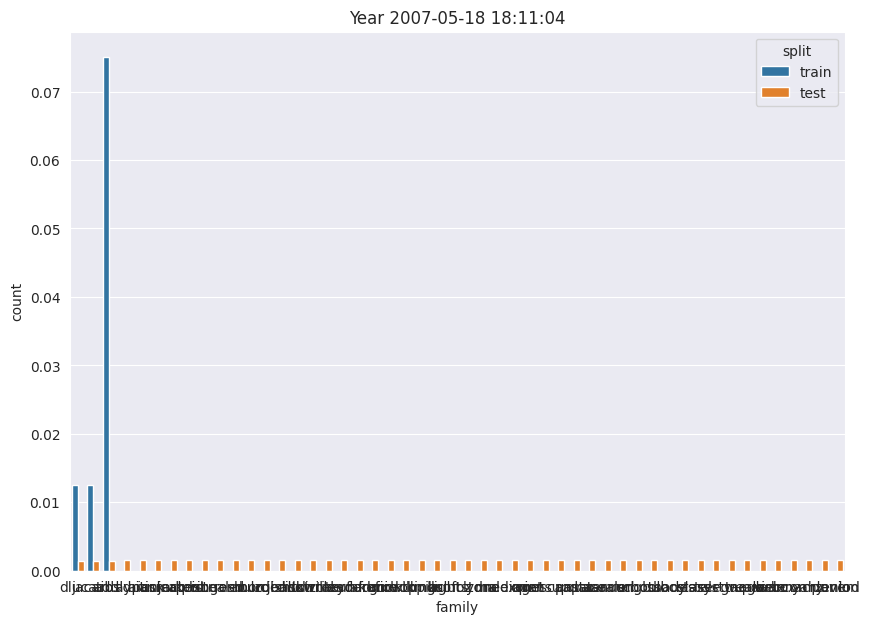

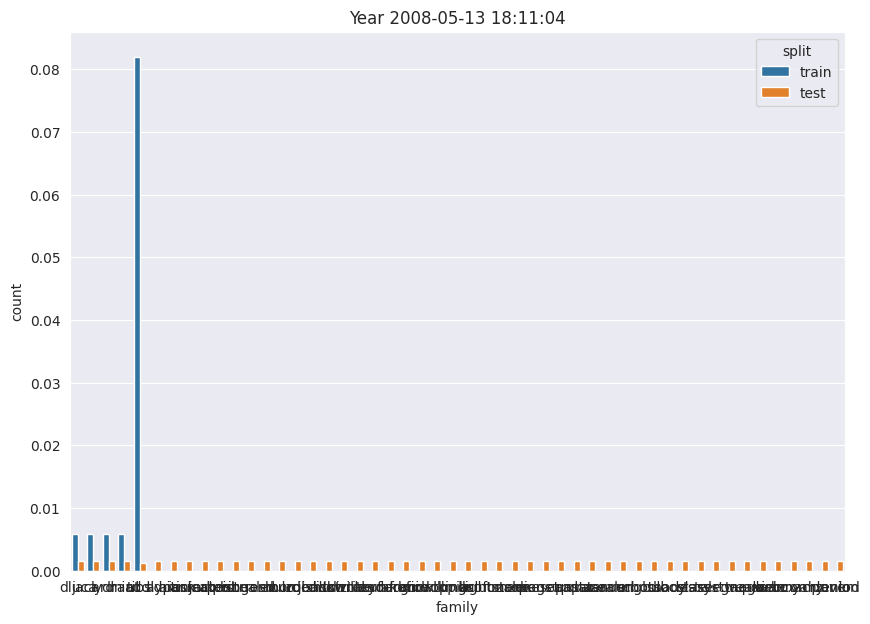

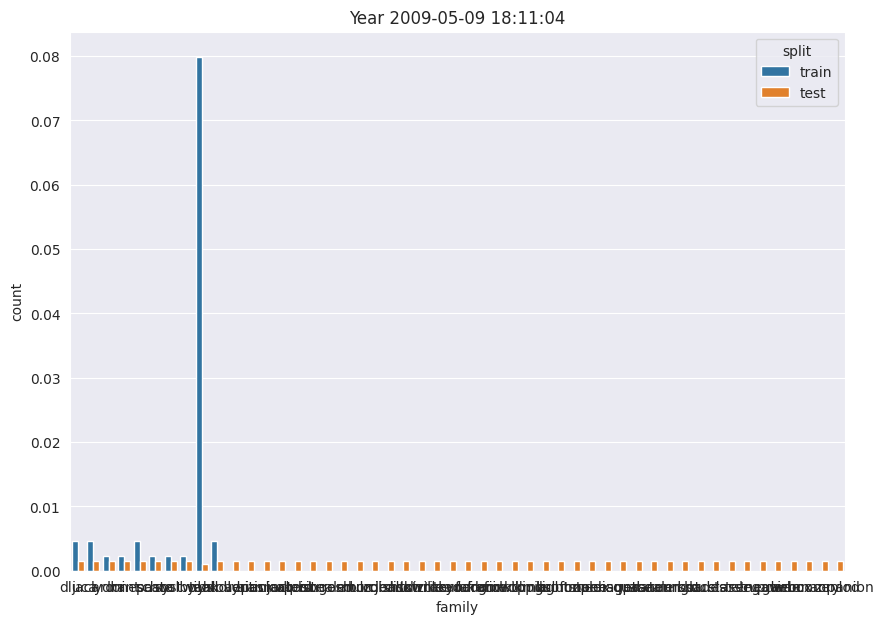

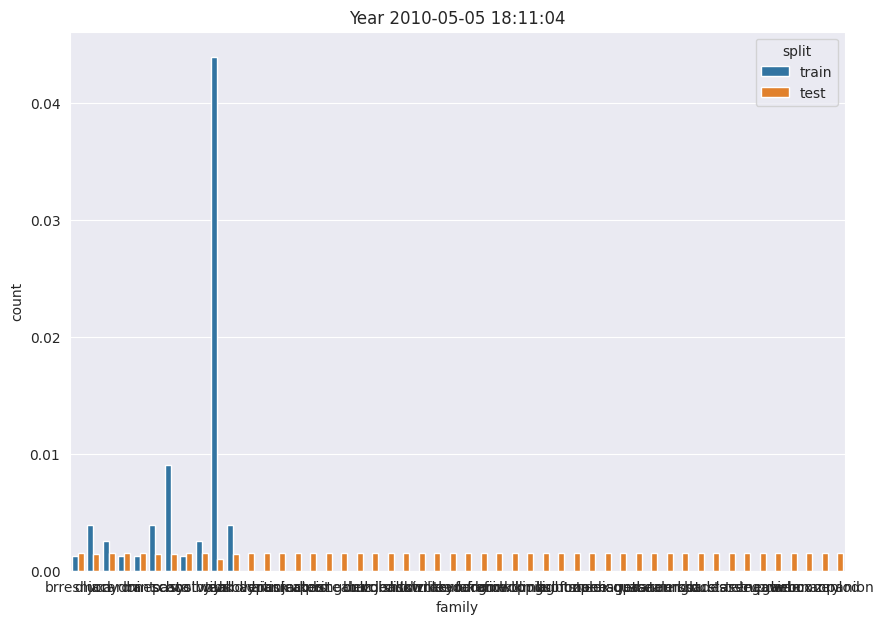

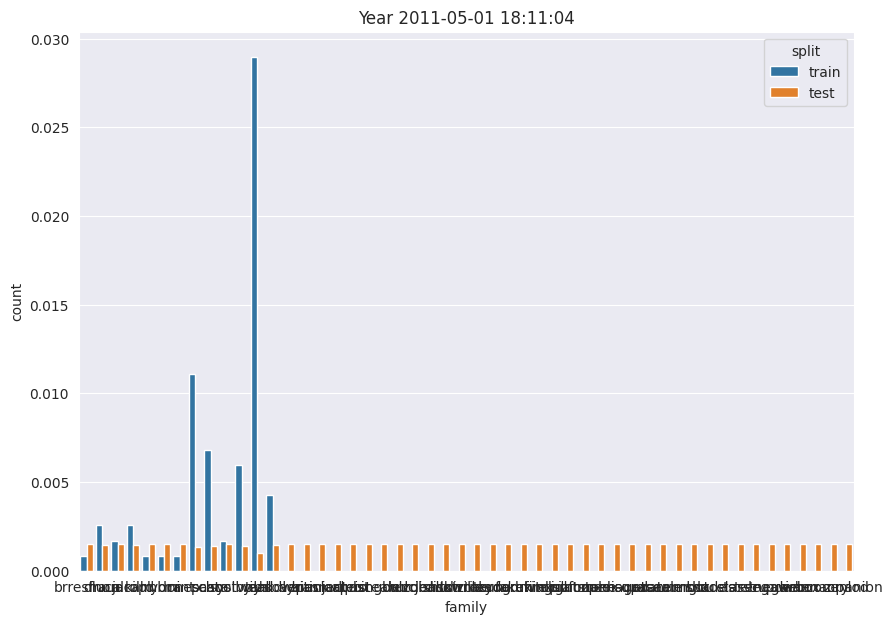

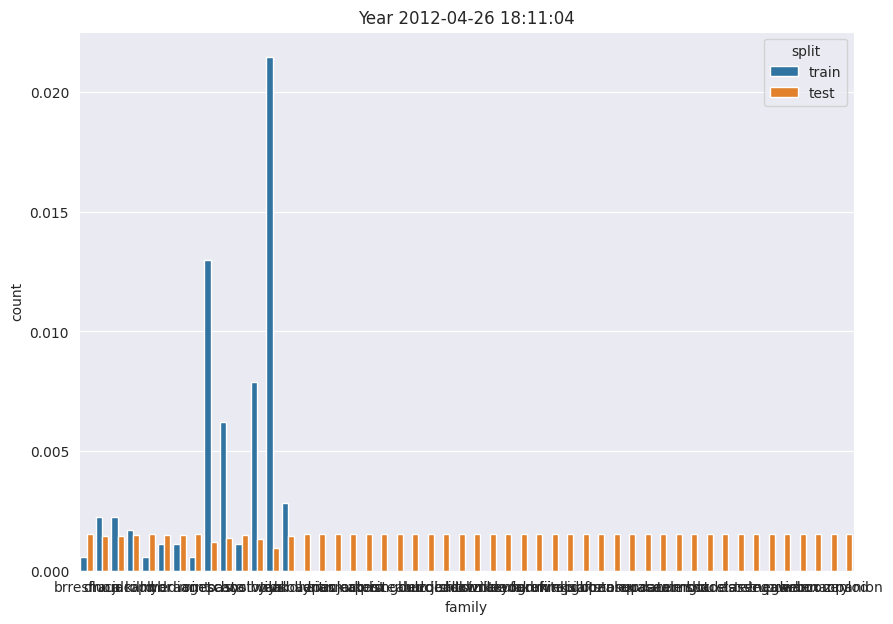

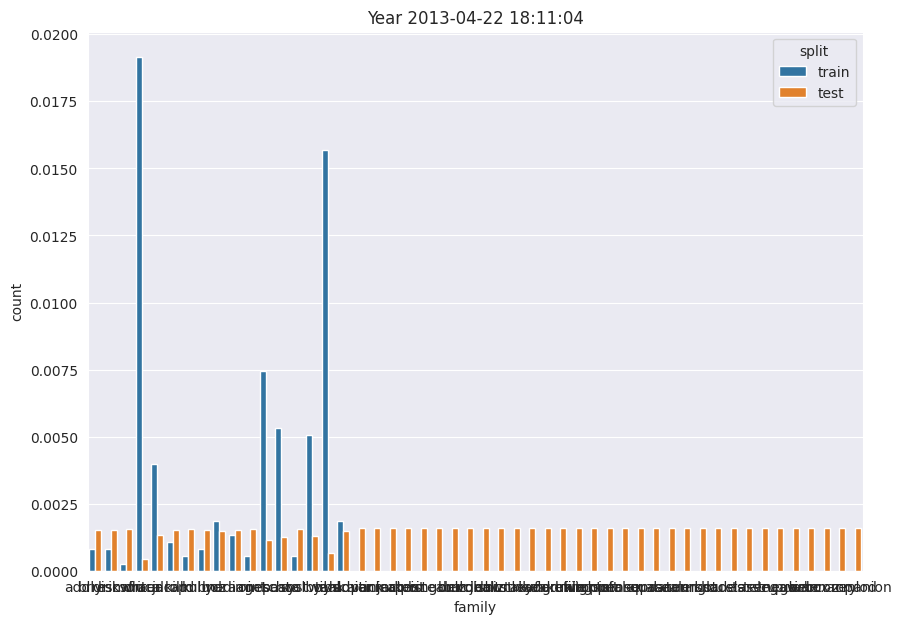

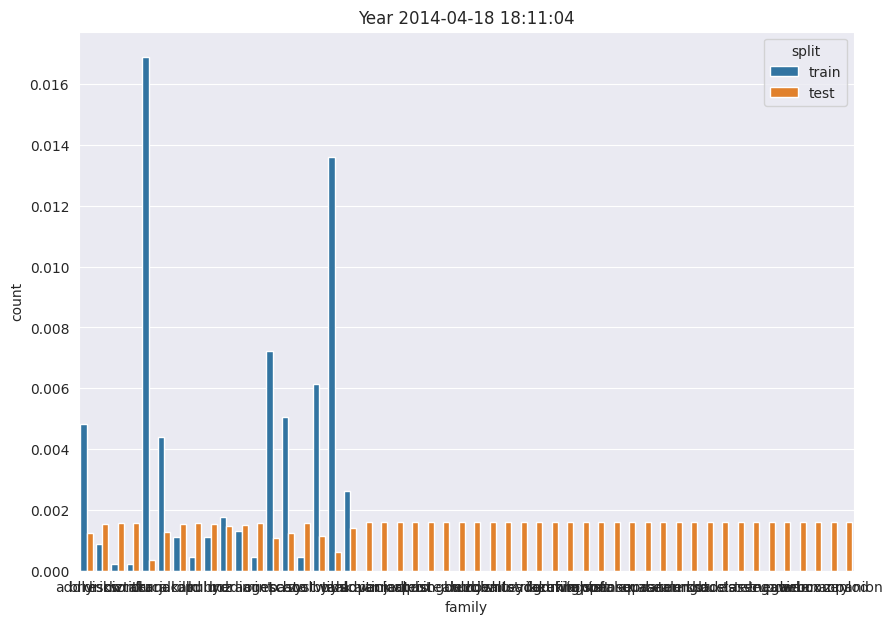

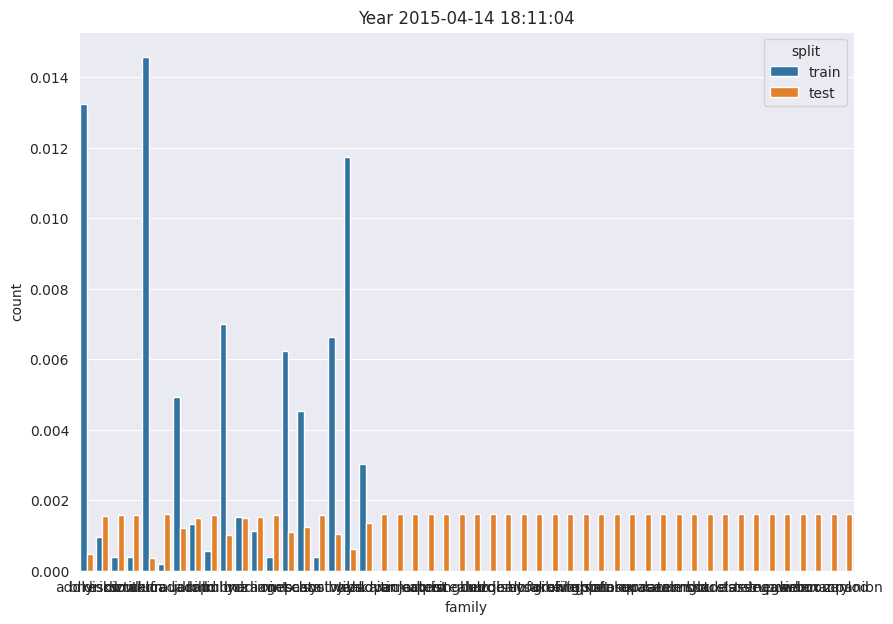

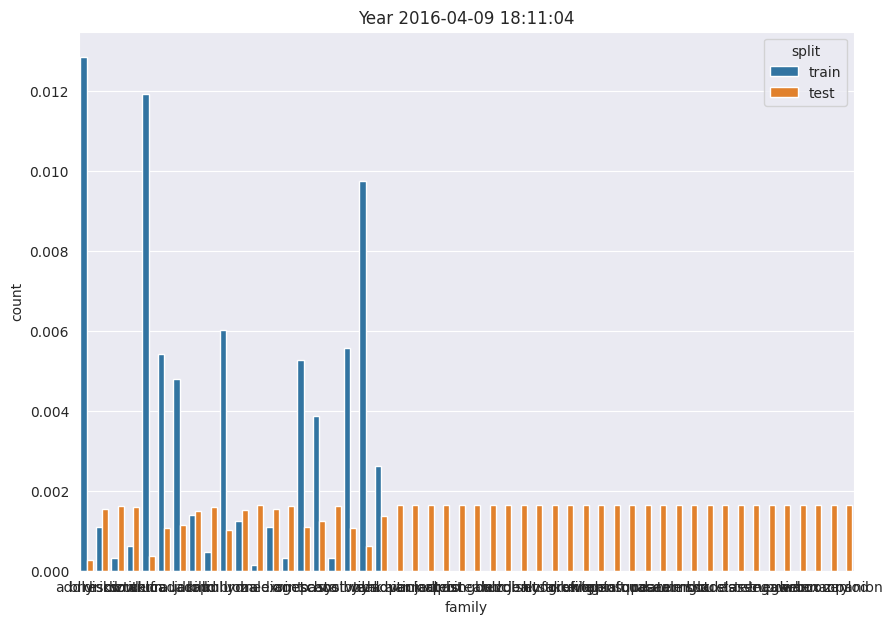

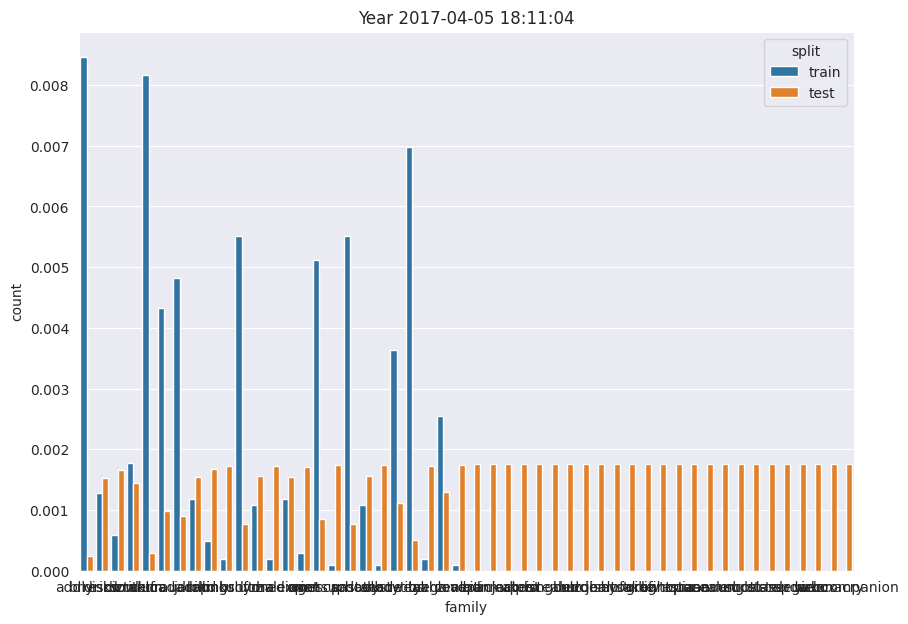

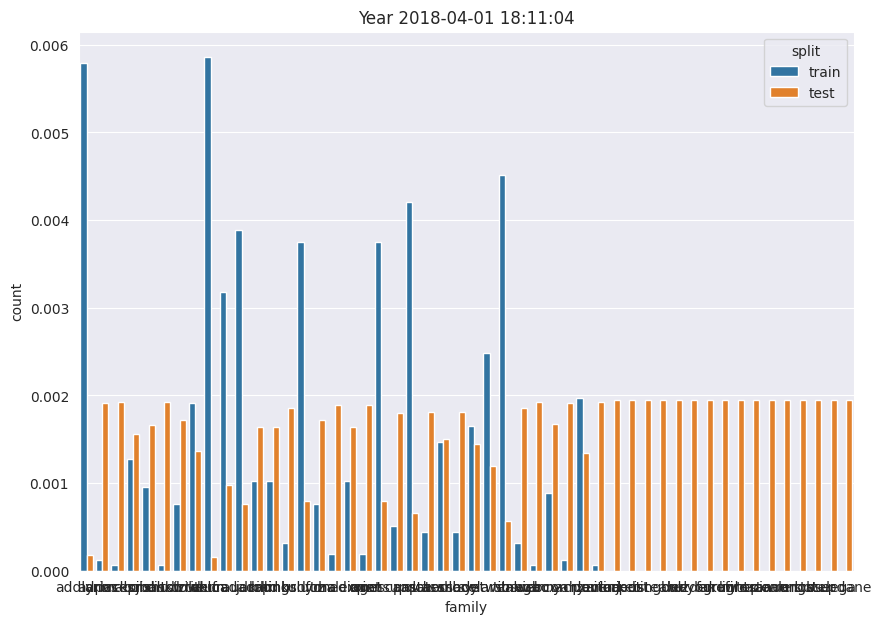

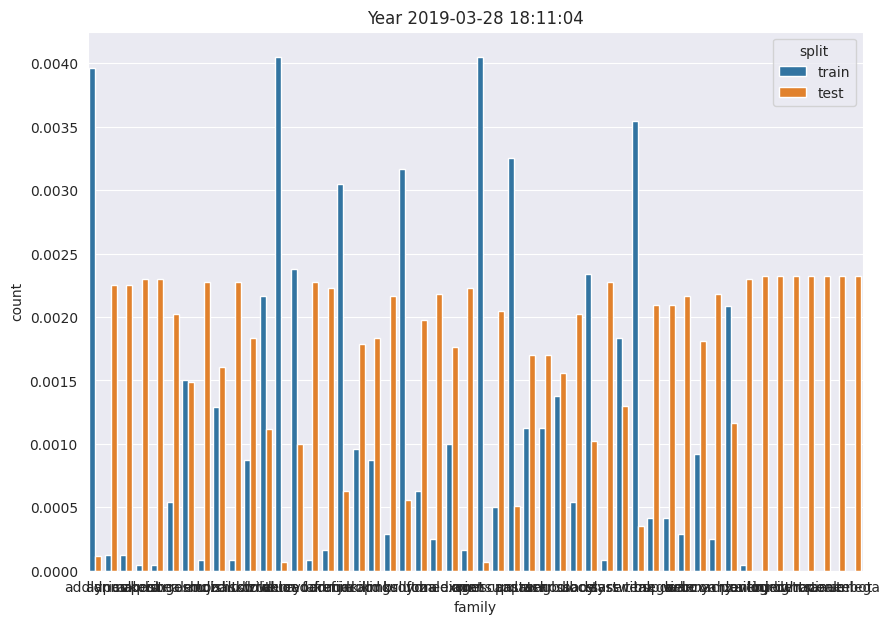

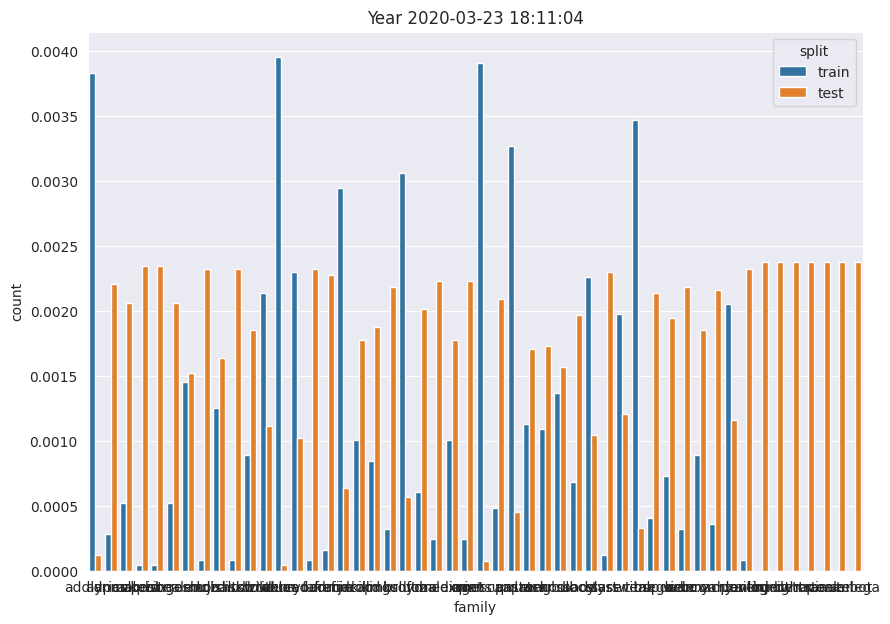

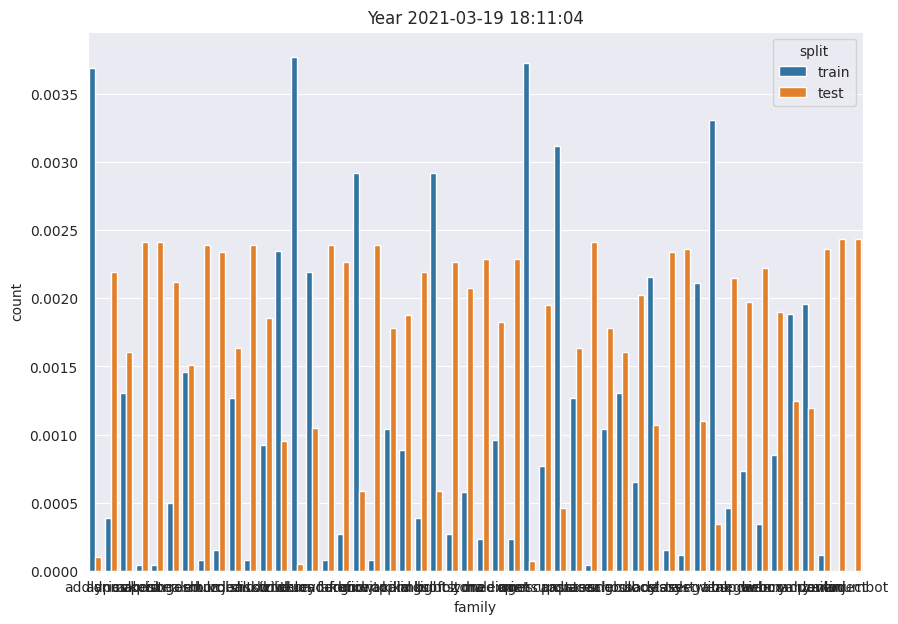

In [47]:
df_split = df_dt.copy()

families = df["family"].unique()[:50]


def split_and_normalize(src_df: pd.DataFrame, split_condition: bool, split_label: str):
    dst_df = src_df[split_condition]
    dst_df = dst_df.groupby(["family"]).size().reset_index(name='count')
    dst_df["count"] = dst_df["count"] / dst_df["count"].sum()
    dst_df["split"] = split_label
    return dst_df


for day in days_range:
    
    # Split the dataset
    df_train = split_and_normalize(df_split, df_split[fsd] < day, "train")
    df_test = split_and_normalize(df_split, df_split[fsd] >= day, "test")

    df_train = df_train[df_train["family"].isin(families)]
    df_test = df_test[df_test["family"].isin(families)]

    df_merge = pd.concat([df_train, df_test])

    # Plot the distribution of first submissions over time
    plt.figure(figsize=(10, 7))
    plt.title(f"Split {day}")
    sns.barplot(data=df_merge, x="family", y="count", hue="split")
    plt.show()

In [ ]:
from scipy.special import kl_div
from scipy.stats import entropy

max_date = df1[fsd].max()
min_date = df1[fsd].min()

year_range = [int(d.strftime('%Y')) for d in
              pd.date_range(start=min_date, end=max_date, freq='Y').tolist()]

df2 = df1.copy()
df2[fsd] = df1[fsd].apply(lambda d: int(d.strftime('%Y')))

families = df["family"].unique()


def get_count(df):
    df_augment = pd.DataFrame({"family": [family for family in families
                                          if family not in df["family"].values]})
    df_augment["count"] = 0
    return pd.concat([df_augment, df.groupby(["family"]).size().reset_index(name='count')])["count"]


def kl_divergence(p, q):
    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-8

    p = np.clip(p, epsilon, 1 - epsilon)
    q = np.clip(q, epsilon, 1 - epsilon)

    # Calculate KL divergence
    return np.sum(p * np.log(p / q))
    #return np.sum(np.where(p != 0, p * np.log(p / q), 0))


def euclidian_distance(l1, l2):
    differences = [after - before for after, before in zip(l1, l2)]
    return np.sqrt(np.sum([diff ** 2 for diff in differences]))


euclidian_distances = []
for year in year_range:
    # Split the dataset into two parts
    first_df = df2[df2[fsd] <= year]
    sec_df = df2[df2[fsd] > year]
    euclidian_distances.append(
        euclidian_distance(list(get_count(first_df)), list(get_count(sec_df)))
    )

print(euclidian_distances)
np.argmax(euclidian_distances)

#print(kl_div(list(get_count(first_df)), list(get_count(sec_df))))
#kl_divergence(get_count(first_df), get_count(sec_df))



In [ ]:
# import numpy as np
# from scipy.stats import ks_2samp
# from sklearn.metrics import pairwise_distances
# from scipy.spatial import distance
# 
# # Sample data before and after time t
# data_before_t = np.random.normal(loc=0, scale=1, size=1000)
# data_after_t = np.random.normal(loc=1, scale=1, size=1200)  # Different size
# 
# # KS Test
# ks_statistic, ks_p_value = ks_2samp(data_before_t, data_after_t)
# print(f'KS Statistic: {ks_statistic}, p-value: {ks_p_value}')
# 
# # Jensen-Shannon Divergence
# def jensen_shannon_divergence(p, q):
#     m = 0.5 * (p + q)
#     return 0.5 * (distance.jensenshannon(p, m) + distance.jensenshannon(q, m))
# 
# # Convert data to probability distributions
# hist_before_t, bin_edges = np.histogram(data_before_t, bins=50, density=True)
# hist_after_t, _ = np.histogram(data_after_t, bins=bin_edges, density=True)
# 
# # Ensure both distributions have the same size for JSD calculation
# min_size = min(len(hist_before_t), len(hist_after_t))
# jsd = jensen_shannon_divergence(hist_before_t[:min_size], hist_after_t[:min_size])
# print(f'Jensen-Shannon Divergence: {jsd}')

In [ ]:
from scipy.stats import chisquare

# observed frequencies
obs1 = [10, 20, 30, 40]
obs2 = [15, 25, 35, 45]

# calculate the Chi-Squared distance
chi2, p = chisquare(f_obs=obs1, f_exp=obs2)

print(chi2)
